In [33]:
import pandas as pd
import csv
import numpy as np
import torch
from matplotlib import pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm

In [10]:
data = pd.read_csv('publ.csv')
data.sample(3)

<ipython-input-10-47bcf7cd181f>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('publ.csv')


,publ_id,publ_name,year,doi,annotation,geo_name,collect_name,collect_type,author_affs,author_ids
72118,1040103,Homoclinic orbits and solitary waves in a one-...,1995,https://doi.org/10.1109/81.473588,The possible propagation of solitary waves in ...,NaN,NaN,NaN,"University of California, San Diego; Universid...",1058733; 1058610; 1006070; 1013880; 1010394
58449,1026434,Multi-objective Order Reduction Problem Solvin...,2017,https://doi.org/10.5220/0006431002700278,NaN,NaN,NaN,NaN,Siberian State Aerospace University,1003074; 1003078; 1003135
78639,1046624,Modelling EMS Maglev systems to develop contro...,2018,https://doi.org/10.35470/2226-4116-2018-7-1-11-17,Electromagnetic suspension (EMS) system for ma...,NaN,NaN,NaN,St Petersburg University,1066521; 1066599; 1066610; 1002271; 1066611; 1...


**Описание признаков:**

publ_id	- Уникальный идентификатор публикации.

year -	Год публикации.

doi	- Digital Object Identifier Уникальный идентификатор для электронных документов.

annotation -	Аннотация или краткое содержание публикации. Это текстовое поле может содержать основные идеи или выводы работы.

geo_name -	Географическое название, связанное с публикацией.

collect_name -	Название коллекции, к которой принадлежит публикация.

collect_type -	Тип коллекции, например, журнал, конференция, книга и т.д. Это помогает классифицировать тип публикации.

author_affs	- Аффилиации авторов.

author_ids - Идентификаторы авторов.

Часть признаков не нужны в исследовании, поэтому удалим их.

In [11]:
data = data.drop(['doi','collect_name','author_affs','author_ids'], axis=1)

Посмотрим содержание пустых строк в датасете

<Axes: >

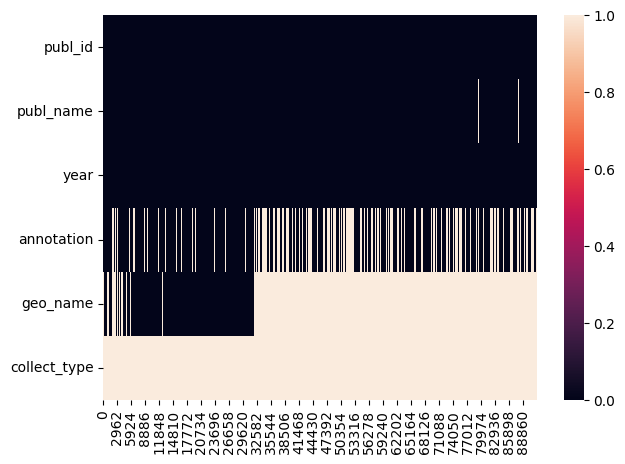

In [12]:
plt.figure(figsize=(7,5))
sns.heatmap(data.isna().transpose())

Видим, что много пустых значений в geo_name и collect_type, поэтому также удалим эти столбцы. Дополнительно удалим строки не содержашие аннотации и название публикации.

In [13]:
data = data.drop(['geo_name','collect_type'], axis=1)

In [14]:
data = data.dropna()

Разделим датасет на два: статьи на русском и английском языках. Для этого создадим дополнительный признак, содержащий информацию о языке.

In [15]:
def is_russian(text):
    return bool(re.search(r'[а-яА-Я]', text))

In [16]:
data['language'] = data['annotation'].apply(lambda x: 'ru' if is_russian(x) else 'en')

data_ru = data[data['language'] == 'ru']
data_en = data[data['language'] == 'en']

In [17]:
data_ru.shape

(23500, 5)

In [18]:
data_en.shape

(42393, 5)

In [19]:
data_ru # название и аннотация на разных языках...

,publ_id,publ_name,year,annotation,language
0,1,Методы и средства волнового фитоуправления в б...,2005,Рассматриваются методы и средства волнового фи...,ru
1,2,Метод динамической компенсации в задаче оценив...,2005,В докладе рассматривается задача стабилизации ...,ru
2,3,Управление электромеханическими системами в ус...,2005,Рассматривается задача управления угловым поло...,ru
4,5,Задача стабилизации линейных систем с сигмоида...,2005,Предложена декомпозиционная процедура синтеза ...,ru
5,6,Скользящий электропривод постоянного тока,2005,В работе рассмотрена задача позиционирования д...,ru
...,...,...,...,...,...
91706,1059691,"CALCULATION OF TECHNOLOGICAL PROCESS, IMPROVEM...",2016,На основе обобщения известных исследований исп...,ru
91751,1059736,Methods of Estimation of Security of Computer ...,2019,В работе разработаны методы оценки защищенност...,ru
91755,1059740,Индустрия 4.0: возможности и риски в контексте...,2020,Представлен обзор проблематики обеспечения инф...,ru
91759,1059744,Security Architectures in Digital Economy Systems,2020,В работе рассматривается задача защиты информа...,ru


In [25]:
classes = pd.read_excel('Classes.xlsx')         # Должен содержать колонки 'class' и 'term'
classes.head(10)

,Факторы классификации,1-й уровень,2-й уровень,ТЕРМИНЫ
0,Общенаучные термины,NaN,NaN,NaN
1,NaN,Общенаучные термины,Общенаучные термины,"абстрагирование, агент, агрегирование, адаптац..."
2,Математический аппарат,NaN,NaN,NaN
3,NaN,Алгебра и теория чисел,NaN,"алгебра, теория чисел"
4,NaN,NaN,Теория чисел,"алгебраические числа, взаимно простые числа, г..."
5,NaN,NaN,"Линейная алгебра, теория матриц","базис, векторное пространство, детерминант, ев..."
6,NaN,NaN,Группы и алгебры Ли,"алгебра Ли, алгебры Картана, группа Ли, мера Х..."
7,NaN,NaN,Решетки и Булевы алгебры,"булева алгебра, дистрибутивная решетка, кванто..."
8,NaN,NaN,Универсальная алгебра,"n-арная операция, алгебраическая структура, гр..."
9,NaN,NaN,Дифференциальная алгебра,"D-module, Д-модули, алгебра Вейля, голономные ..."


Рассмотрим пока 2ой уровень и термины

In [26]:
classes = classes.drop(['Факторы классификации','1-й уровень'], axis=1)
classes = classes.dropna()
classes.head()

,2-й уровень,ТЕРМИНЫ
1,Общенаучные термины,"абстрагирование, агент, агрегирование, адаптац..."
4,Теория чисел,"алгебраические числа, взаимно простые числа, г..."
5,"Линейная алгебра, теория матриц","базис, векторное пространство, детерминант, ев..."
6,Группы и алгебры Ли,"алгебра Ли, алгебры Картана, группа Ли, мера Х..."
7,Решетки и Булевы алгебры,"булева алгебра, дистрибутивная решетка, кванто..."


In [ ]:
# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

In [44]:
term_to_class = {}
for index, row in classes.iterrows():
    class_name = row['2-й уровень']
    terms = row['ТЕРМИНЫ'].split(',')

    for term in terms:
        term = term.strip()  # Удаление лишних пробелов
        term_to_class[term] = class_name

        # tokens = word_tokenize(term.lower())  # Приводим к нижнему регистру
        # lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        # term_to_class[lemmatized_tokens] = class_name

term_to_class


{'абстрагирование': 'Общенаучные термины',
 'агент': 'Общенаучные термины',
 'агрегирование': 'Общенаучные термины',
 'адаптация': 'Общенаучные термины',
 'адекватный': 'Общенаучные термины',
 'аксиома': 'Общенаучные термины',
 'активность': 'Общенаучные термины',
 'актуальность': 'Общенаучные термины',
 'алгоритм': 'Общенаучные термины',
 'альтернатива': 'Общенаучные термины',
 'анализ': 'Общенаучные термины',
 'аналогия': 'Общенаучные термины',
 'аппарат': 'Общенаучные термины',
 'аспект': 'Общенаучные термины',
 'атрибут': 'Общенаучные термины',
 'величина': 'Общенаучные термины',
 'верификация': 'Общенаучные термины',
 'вид': 'Общенаучные термины',
 'внедрение': 'Общенаучные термины',
 'внешняя среда': 'Общенаучные термины',
 'вопрос': 'Общенаучные термины',
 'выбор': 'Общенаучные термины',
 'выборка': 'Анализ данных',
 'гипотеза': 'Общенаучные термины',
 'дальновидность': 'Общенаучные термины',
 'дедукция': 'Моделирование рассуждений',
 'действие': 'Общенаучные термины',
 'декомпо

In [50]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для нормализации текста и классификации аннотации
def classify_annotation(text):
    found_classes = set()

    # Приводим текст к нижнему регистру и токенизируем его один раз
    text_lower = text.lower()
    tokens = word_tokenize(text_lower)
    lemmatized_tokens = {lemmatizer.lemmatize(token) for token in tokens}  # Используем множество

    # Проверка наличия терминов в тексте
    for term, class_name in term_to_class.items():
        normalized_term = term.lower()

        # Проверяем наличие термина в тексте (как целой фразы)
        if normalized_term in text_lower:
            found_classes.add(class_name)

        # Альтернативный вариант с регулярным выражением (если требуется)
        if re.search(r'\b' + re.escape(normalized_term) + r'\b', text_lower):
            found_classes.add(class_name)

    return list(found_classes)

# Применение функции к каждой аннотации
data_ru['class'] = data_ru['annotation'].apply(classify_annotation)
#result = data_ru['annotation'][:100].apply(classify_annotation)
#result
data_ru

KeyboardInterrupt: 

In [ ]:
data_ru.to_csv('data_ru.csv', index=False)

In [47]:
# Функция для нормализации текста и классификации аннотации
def classify_annotation(text):
    found_classes = set()

    # Токенизация и лемматизация текста
    tokens = word_tokenize(text.lower())  # Приводим к нижнему регистру
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Проверка наличия терминов в тексте
    for term, class_name in term_to_class.items():

        tokens = word_tokenize(term.lower())
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Проверяем наличие термина в тексте (как целой фразы)
        if re.search(r'\b' + re.escape(lemmatized_tokens.encode('utf-8')) + r'\b', text.lower()):
            found_classes.add(class_name)

    return list(found_classes)

from joblib import Parallel, delayed

# Параллельная обработка аннотаций
#results = Parallel(n_jobs=-1)(delayed(classify_annotation)(text) for text in data_ru['annotation'][:100])
#data_ru['class'] = results
results = data_ru['annotation'][:100].apply(classify_annotation)

# Вывод результатов
#data_ru.head()
results

AttributeError: 'list' object has no attribute 'encode'

Найдем самые популярные темы исследования для определения целевой функции. Это можно сделать частотным методом, выбрав самые встречающиеся темы из названия статей.

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [31]:
 nltk.download('stopwords')
 nltk.download('punkt')
 nltk.download('wordnet')
stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
titles = data_ru['annotation']

processed_titles = titles.apply(preprocess_text)

all_words = ' '.join(processed_titles).split()

bigrams = ngrams(all_words, 2)
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(10)
print("Самые популярные темы исследования:")
for bigram, count in most_common_bigrams:
    print(f"{' '.join(bigram)}: {count}")

In [ ]:
bigrams = ngrams(all_words, 3)
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(10)
print("Самые популярные темы исследования:")
for bigram, count in most_common_bigrams:
    print(f"{' '.join(bigram)}: {count}")

In [ ]:
bigrams = ngrams(all_words, 4)
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(10)
print("Самые популярные темы исследования:")
for bigram, count in most_common_bigrams:
    print(f"{' '.join(bigram)}: {count}")

In [ ]:
def recommend_articles(user_preferences):
    # Фильтрация статей по предпочтениям пользователя
    recommended = data[data['annotation'].str.contains('|'.join(user_preferences), case=False)]

    # Сортировка по популярности (можно добавить больше критериев)
    recommended = recommended.sort_values(by='year', ascending=False)  # или другой признак
    return recommended[['publ_id', 'publ_name', 'year']]

In [ ]:
# Числовые признаки
num_cols = [
    'publ_id',
    'year'
]

# Категориальные признаки
cat_cols = [
    'publ_name',
    'annotation',
    'language'
]

feature_cols = num_cols + cat_cols
target_col = '?'